# Systematics in DR9
In this notebook, we explore the model that is trained with 3/5 of the data, and then applied to mitigate systematics. Applied on one partition (i.e., 3/5 of data) with one chain up to 300 epochs took about 12 min. Learning rate is cyclic with warm restarts, whose parameters are adjusted based on Smith 2015. The optimizer is Adam (AdamW), and the cost function is MSE.

In [1]:
import numpy as np
import fitsio as ft
import healpy as hp

import sys
sys.path.insert(0, '/home/mehdi/github/sysnetdev')
sys.path.insert(0, '/home/mehdi/github/LSSutils')

from lssutils.utils import hpix2radec
from lssutils.stats.nnbar import MeanDensity
from lssutils.dataviz import mycolor

from sysnet.sources.train import evaluate
from sysnet.sources.models import DNN
from sysnet.sources.losses import init_loss
from sysnet.sources.io import load_checkpoint, ImagingData, MyDataSet, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
def run(cap='N'):
    # --- read data
    data = ft.read(f'/home/mehdi/github/dr9/results/dr9m_elg_{cap}.fits')
    metrics = np.load(f'/home/mehdi/github/dr9/results/regression/elg/{cap}/nn_all_256/metrics.npz', allow_pickle=True)



    # --- read model
    chck = f'/home/mehdi/github/dr9/results/regression/elg/{cap}/nn_all_256/model_0_779908599/best.pth.tar'
    model = DNN(4, 20, input_dim=13)
    checkpoint = load_checkpoint(chck, model)

    img_data = ImagingData(data, checkpoint['stats'])

    dataloader = DataLoader(MyDataSet(img_data.x, img_data.y, img_data.p, img_data.w),
                             batch_size=4098,
                             shuffle=True,
                             num_workers=0)
    
    
    # --- loss 
    Loss, loss_kw = init_loss('mse')  
    loss_fn = Loss(**loss_kw)

    result = evaluate(model, loss_fn, dataloader, {'device':'cpu'}, return_ypred=True)


    loss_p, hpix_p, ngal_p = result
    hpix_p = hpix_p.numpy()
    ngal_p = ngal_p.numpy().flatten()

    npred_ = np.zeros(12*256*256)
    npred_[hpix_p] = ngal_p
    npred = npred_[data['hpix']]
    
    nbar_true = MeanDensity(data['label'], data['fracgood'], data['fracgood']>0, data['features'][:, 1])
    nbar_pred = MeanDensity(npred*data['fracgood'], data['fracgood'], data['fracgood']>0, data['features'][:, 1])
    nbar_corr = MeanDensity(data['label'], data['fracgood'], data['fracgood']>0, data['features'][:, 1], selection=npred)

    nbar_true.run()
    nbar_pred.run()
    nbar_corr.run()
    
    plt.figure()
    for nmi, nbi in zip(['Observed', 'Modeled', 'Observed (corrected)'],
                    [nbar_true, nbar_pred, nbar_corr]):
        plt.errorbar(nbi.output['bin_avg'], nbi.output['nnbar']-1, 
                 nbi.output['nnbar_err'], capsize=2, marker='o', label=nmi, mfc='w')
    
    plt.axhline(0.0, ls=':', lw=1, alpha=0.5)    
    #plt.xscale('log')
    plt.ylabel(r'$\delta$')
    #plt.xlabel('E[B-V]')
    #plt.xlabel('PSFDEPTH-W1')
    plt.legend(title=f'ELG-{cap} DR9m')
    plt.show()
    
    
    plt.figure()
    losses = metrics['losses'].item()
    for n_, loss_ in losses.items():
        if n_ == 'test':
            continue

        plt.plot(loss_[0][0], label=n_)

    ymin = 0.98*min(losses['train'][0][0])
    ymax = losses['train'][0][0][10]
    
    plt.ylim(ymin, ymax)
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    
    ra, dec = hpix2radec(256, data['hpix'])
    pixarea = hp.nside2pixarea(256, degrees=True)
    fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)

    fig.subplots_adjust(wspace=0.0)

    kw = dict(cmap=mycolor(), vmin=1500., vmax=3500.)


    sindec = np.sin(np.deg2rad(dec))

    cax = plt.axes([0.3, -0.1, 0.4, 0.04])


    ax[0].scatter(ra, sindec, 2, c=data['label']/(data['fracgood']*pixarea), **kw)


    ax[1].scatter(ra, sindec, 2, c=npred/pixarea, **kw)

    map1 = ax[2].scatter(ra, sindec, 2, c=data['label']/(data['fracgood']*pixarea*npred/npred.mean()), **kw)


    fig.colorbar(map1, cax=cax, label=r'n [deg$^{-2}$]', 
                 extend='both', orientation='horizontal')



    ax[1].set_xlabel('RA [deg]')
    ax[0].set_ylabel('sin(DEC)')
    plt.show()

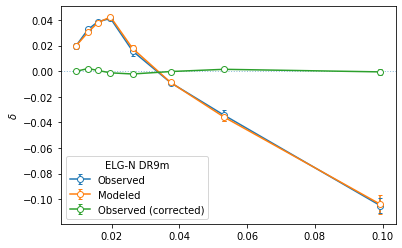

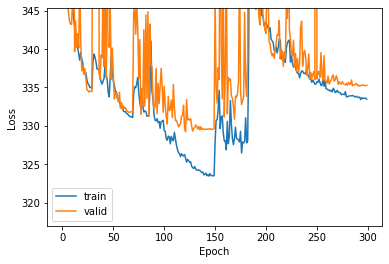

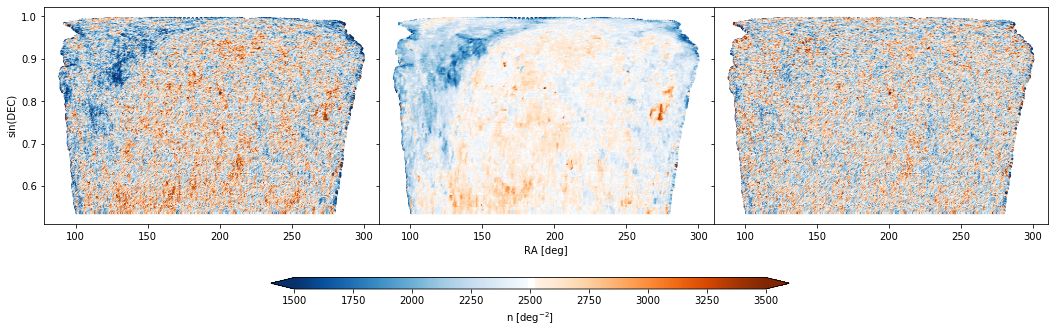

In [16]:
run('N')

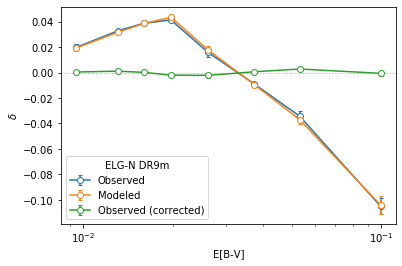

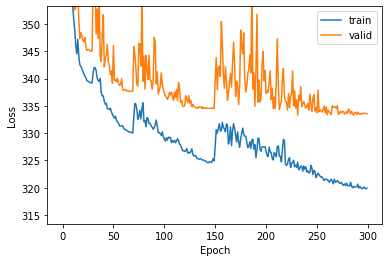

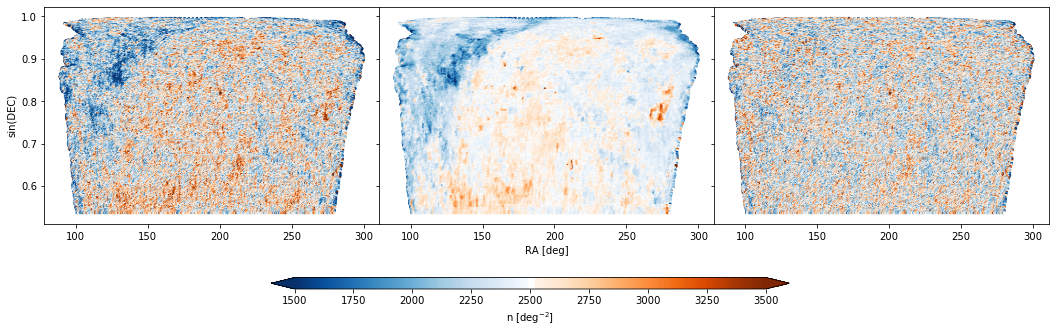

In [3]:
run('N')

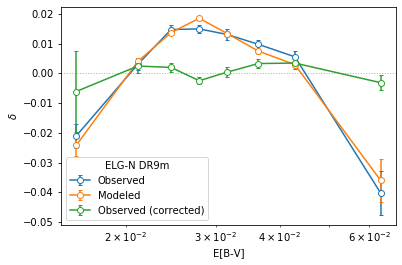

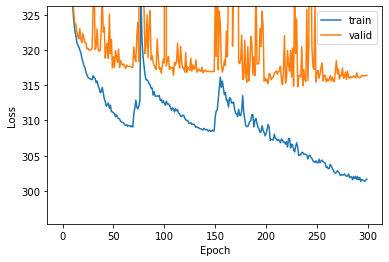

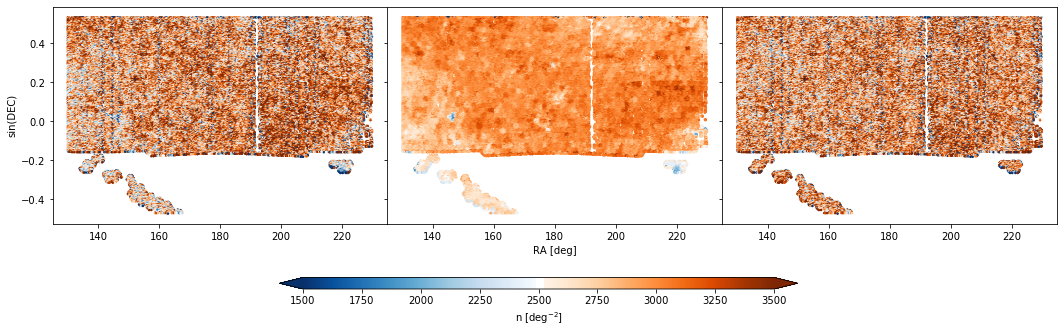

In [4]:
run('S')

In [9]:
from glob import glob

In [10]:
cap = 'N'
def get_weights(cap, model_id=0, vmin=None, vmax=None):
    
    # --- read model
    chck_ = f'./results/regression/elg/{cap}/nn_all_256/model_*/best.pth.tar'
    models = glob(chck_)
    chck = models[model_id]
    
    model = DNN(4, 20, input_dim=13)
    checkpoint = load_checkpoint(chck, model)
    
    hl1 = abs(model.fc[0].weight.detach().numpy())
    
    plt.imshow(hl1.sum(axis=0)[:,np.newaxis], cmap=plt.cm.jet, origin='lower', vmin=vmin,
               vmax=vmax)
    plt.yticks(np.arange(13), ['STARDENS', 'EBV', 
                          'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 
                          'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 
                          'PSFDEPTH_W1', 'PSFDEPTH_W2',
                          'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z'])
    plt.xticks([])
    plt.colorbar(label=r'$\sum_{j}{|w_{ij}|}$')
    plt.show()

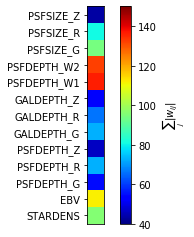

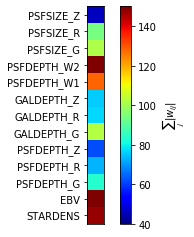

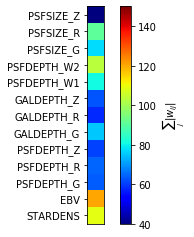

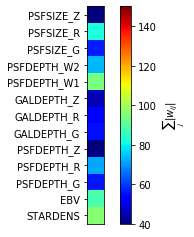

In [16]:
for model_id in [0, 1, 10, 12]:
    get_weights('N', model_id=model_id, vmin=40, vmax=150)

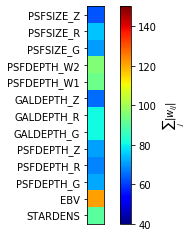

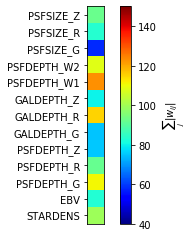

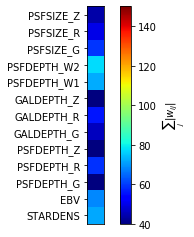

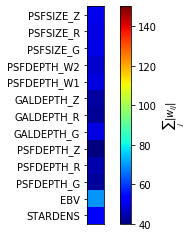

In [18]:
for model_id in [0, 1, 10, 12]:
    get_weights('S', model_id=model_id, vmin=40, vmax=150)

In [44]:
cap = 'N'
data = ft.read(f'/Users/mehdi/dr9/results/dr9m_elg_{cap}.fits')

In [49]:
fs = ['STARDENS', 'EBV', 
                          'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 
                          'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 
                          'PSFDEPTH_W1', 'PSFDEPTH_W2',
                          'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']
for i in range(13):
    print(i, fs[i], np.percentile(data['features'][:, i], [0, 10, 90, 100]))

0 STARDENS [   76.25460052   343.14569092  1944.49230957 10866.28027344]
1 EBV [0.0035661  0.01099817 0.07525405 0.41836196]
2 PSFDEPTH_G [   0.          513.86268311  942.10142822 2106.68994141]
3 PSFDEPTH_R [  0.         170.41635437 318.04488525 778.72821045]
4 PSFDEPTH_Z [  0.          81.90198059 167.36359863 438.24404907]
5 GALDEPTH_G [   0.          382.97371216  674.2644165  1619.5435791 ]
6 GALDEPTH_R [  0.         120.40137329 213.36349182 555.48297119]
7 GALDEPTH_Z [  0.          47.24756012  86.64902496 205.85464478]
8 PSFDEPTH_W1 [ 1.55081129  3.31520109  7.31142406 15.10653687]
9 PSFDEPTH_W2 [ 0.63002795  1.0339324   3.03684464 13.1860075 ]
10 PSFSIZE_G [0.         1.6553411  2.2047647  3.31880236]
11 PSFSIZE_R [0.         1.42707853 1.99653044 2.99442315]
12 PSFSIZE_Z [0.         1.06949098 1.45717866 2.69280601]


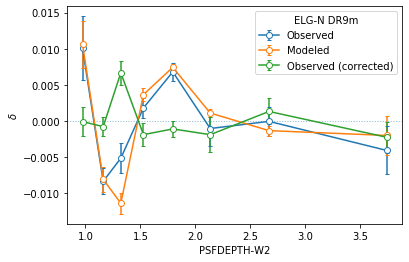

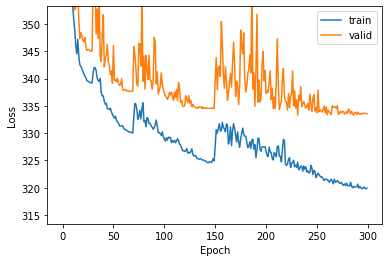

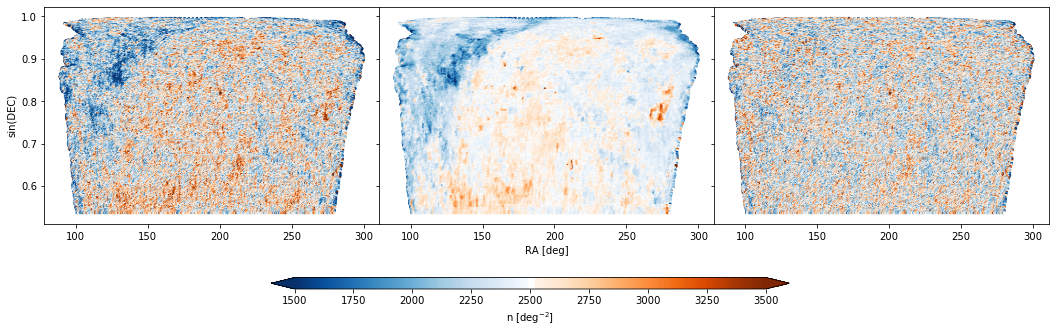

In [6]:
run('N')

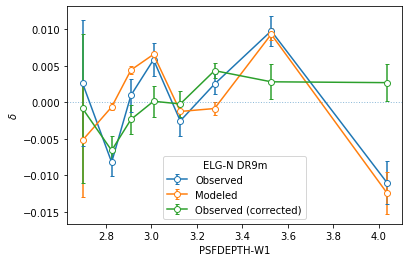

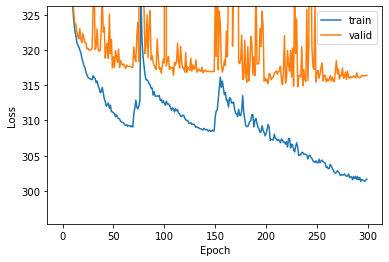

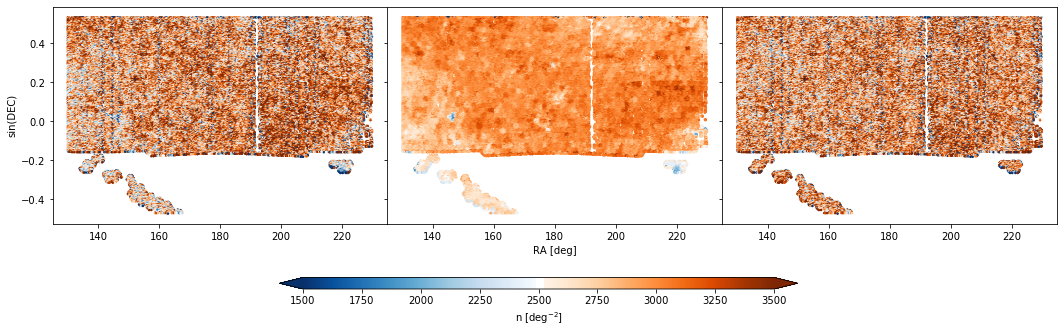

In [9]:
run('S')